**Burger's Equation is a partial differential equation used in fluid dynamics and gas dynamics. It combines advection and diffusion terms to describe the motion of fluids or gases. The equation is valuable for studying shock waves, traffic flow, nonlinear waves, turbulence, and developing numerical methods. It provides insights into fluid behavior and nonlinear phenomena, making it applicable in various scientific and engineering fields.**

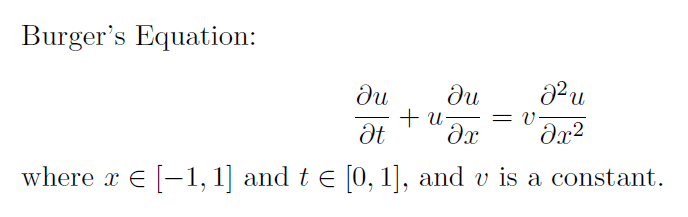

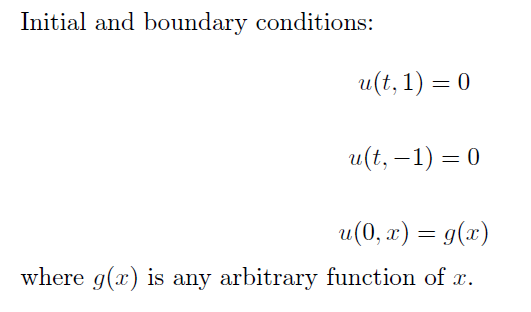

**Re-arranging the terms of the differential equation, We will get:**

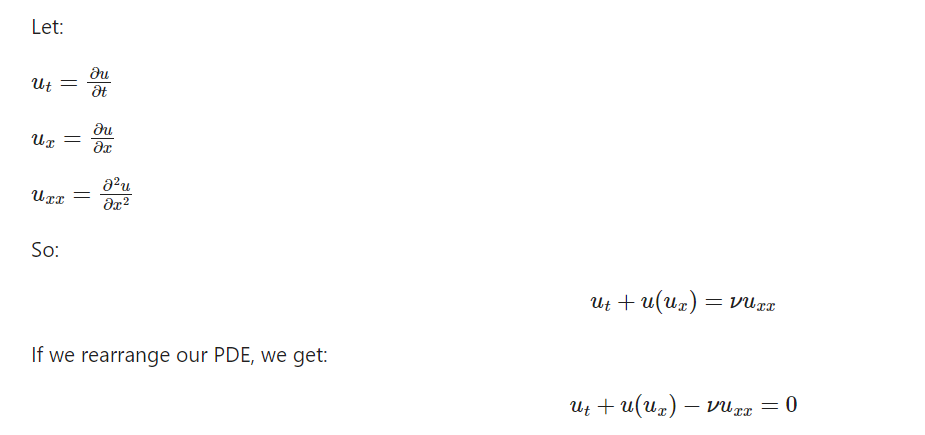



---



**Neural Network as a universal function approximator**

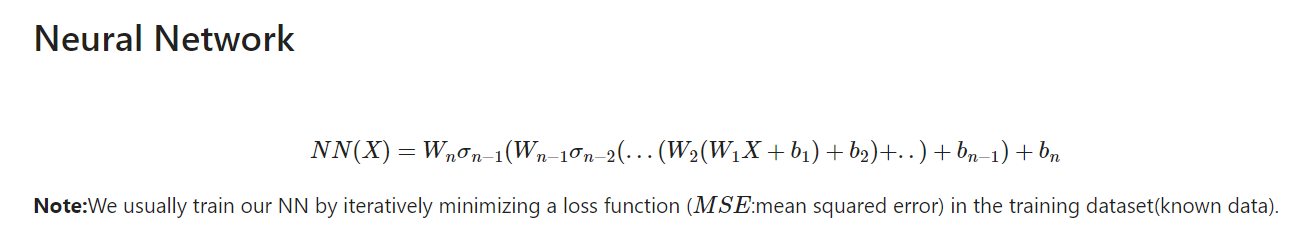

**A very short introduction to Physics Informed Neural Networks**

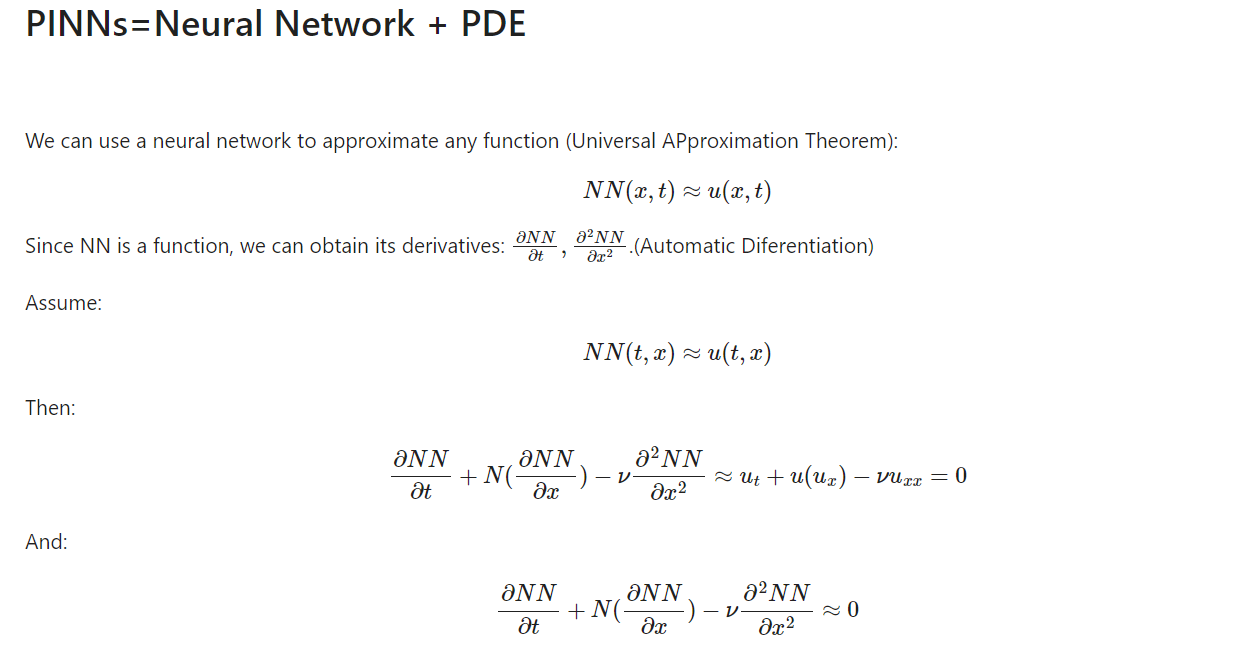



---



**Now, Let's define a loss function for this network, We have two approaches to do so.**

**The first one imposes soft constraints.**

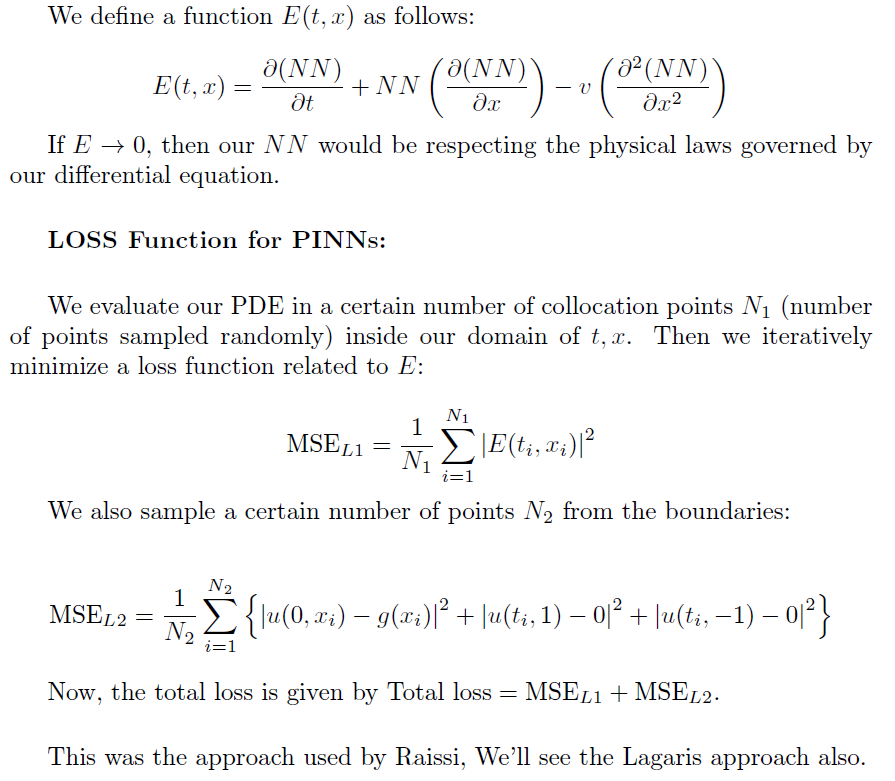

**Now, Let's see the second approach which will impose hard constraints.**

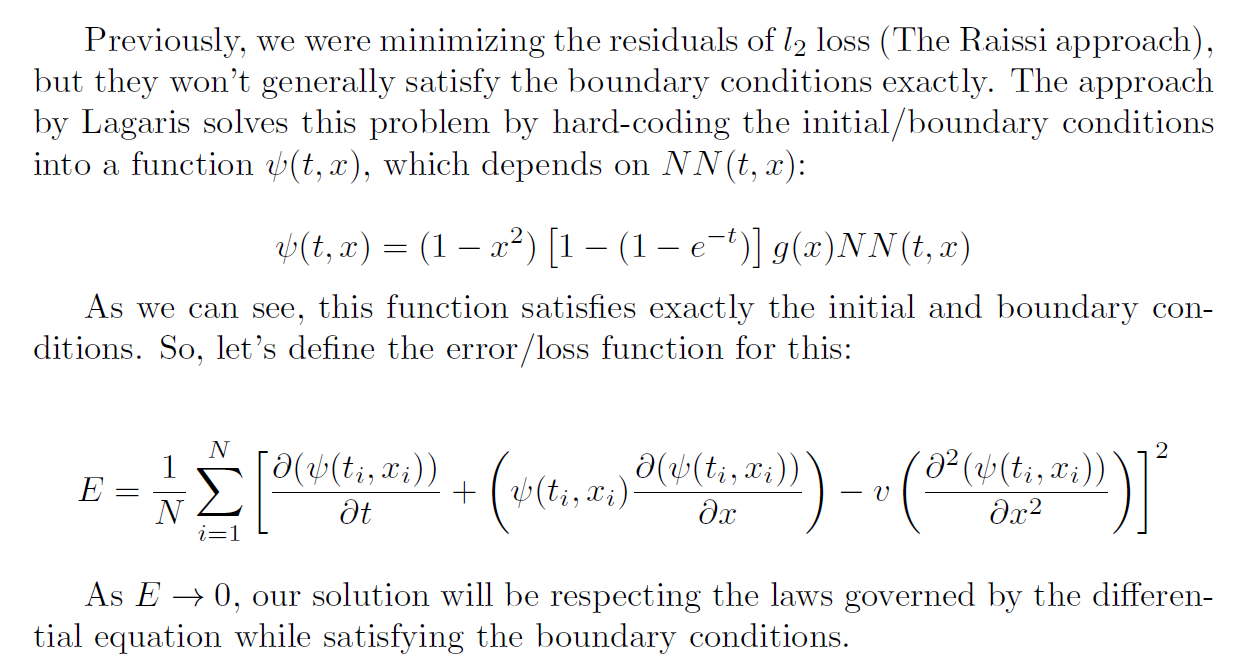

**In this notebook we will be using soft constraints ie the Raissi approach.**

**Traditional numerical methods require discretizing the problem domain and solving a large system of equations, PINNs directly learn the solution from data and governing equations. This can lead to significant reductions in computational cost, especially for problems with high dimensionality or complex geometries. That is one of many reasons to use this new approach known as Physics Informed Neural Networks for solving PDEs.**



---



**Importing the basic dependencies**

In [ ]:
import numpy as np
from random import uniform

import torch
from torch import nn
import torch.optim as optim

**Defining the neural network architechture and forward pass inside a class**

In [ ]:
class NeuralNetwork(nn.Module):
  def __init__(self, layers):

    super().__init__()

    # Defining linear layers with number of neurons specified in the list "layers"
    self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])

    # Defining the activation function
    self.activation=nn.Tanh()

    # Initialising the weights of these layers
    for i in range(len(layers)-1):
      # weights from a normal distribution
      nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
      # set biases to zero
      nn.init.zeros_(self.linears[i].bias.data)

  def forward(self, x, t):

    # vertically stacking x and t to create a matrix which we will pass
    input=torch.cat((x, t), dim=1)

    # forward pass
    for i in range(len(layers)-2):
        z = self.linears[i](input)
        input = self.activation(z)

    input = self.linears[-1](input)
    return input

**Defining some parameters for the Differential Equation :**

In [ ]:
# Number of data points for boundary conditions
N_u=100

# Number of collocation points
N_f=10000

# The constant in the differential equation
constant= 0.01 / np.pi

# The function in the differential equation's initial condition
def f_ic(x):
  #define any function of x that you want here
  #in our example we are taking f_ic(x) = -sin(pie*x)
  return(-np.sin(np.pi*x))

**Setting up the number of layers and loss function**

In [ ]:
# Defining the number of layers with number of neurons in each layer
layers = np.array([2,20,20,20,20,20,20,20,20,1])

# Defining the loss function
loss_function = nn.MSELoss()

# NOTE : We can tune the number of layers/neurons for getting better performance

**Defining the PINN class**

In [ ]:
class PINN():

  def __init__(self, X_u, u_train, X_f ):

    # Getting x & t for boundary conditions:

    self.x_u = torch.tensor(X_u[:, 0].reshape(-1, 1),
                            dtype=torch.float32,
                            requires_grad=True)
    self.t_u = torch.tensor(X_u[:, 1].reshape(-1, 1),
                           dtype=torch.float32,
                           requires_grad=True)

    # Getting x & t for collocation points:

    self.x_f = torch.tensor(X_f[:, 0].reshape(-1, 1),
                            dtype=torch.float32,
                            requires_grad=True)
    self.t_f = torch.tensor(X_f[:, 1].reshape(-1, 1),
                            dtype=torch.float32,
                            requires_grad=True)

    # Solution vector of DE at boundary conditions:

    self.u_train = torch.tensor(u_train, dtype=torch.float32)

    # Solution vector (here it's zero vector) to test against f:

    self.null = torch.zeros((self.x_f.shape[0], 1))

    # Initialize the network:

    self.net = NeuralNetwork(layers)

    # Defining the optimizer
    # This optimizer updates the weights and biases of the net:

    self.optimizer = torch.optim.LBFGS(self.net.parameters(),
                              lr=1,
                              max_iter=50000,
                              max_eval=50000,
                              history_size=50,
                              tolerance_grad=1e-08,
                              tolerance_change=0.5 * np.finfo(float).eps,
                              line_search_fn="strong_wolfe")

    # Loss :
    self.ls = 0

    # Iteration number:
    self.iter = 0

  def u_hat(self, x, t):
    #Defining the function u_hat which is just the output of Neural Network
    #u_hat is used to impose the boundary conditions to the Neural Network
    #By minimising the Boundary Conditions loss

    u_pred=self.net(x,t)
    return u_pred

  def f_hat(self, x, t):
    #Defining the function f_hat which is a function of u_hat and derivatives
    #f_hat is used to impose PDE into the Neural Network by minimising PDE Loss

    u=self.u_hat(x,t)

    u_t = torch.autograd.grad(
            u, t,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True)[0]

    u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True)[0]

    u_xx = torch.autograd.grad(
            u_x, x,
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True)[0]

    f = u_t + (u * u_x) - (constant * u_xx)

    return f

  def closure(self):
    # reset gradients to zero:
    self.optimizer.zero_grad()

    # u & f predictions:
    u_prediction = self.u_hat(self.x_u, self.t_u)
    f_prediction = self.f_hat(self.x_f, self.t_f)

    # losses:
    u_loss = loss_function(u_prediction, self.u_train)
    f_loss = loss_function(f_prediction, self.null)
    self.ls = u_loss + f_loss

    # derivative with respect to net's weights:
    self.ls.backward()

    # increase iteration count:
    self.iter += 1

    # print report:
    if not self.iter % 100:
      print('Epoch: {0:}, Loss: {1:6.9f}'.format(self.iter, self.ls))

    return self.ls

  def train(self):
    """ training loop """
    self.net.train()
    self.optimizer.step(self.closure)

In [ ]:
#Defining a function to generate samples that we will use as training points
#For both boundary conditions and collocation points

def generate_data():

    # For boundary points
    # X_u_train: a set of pairs (x, t) located at:
    # x =  1, t = [0,  1]
    # x = -1, t = [0,  1]
    # t =  0, x = [-1, 1]

    #Defining the helper variables in sampling the training boundary points
    x_upper = np.ones((N_u // 4, 1), dtype=float)
    x_lower = np.ones((N_u // 4, 1), dtype=float) * (-1)
    t_zero = np.zeros((N_u // 2, 1), dtype=float)

    #Sampling random numbers between 0 and 1
    t_upper = np.random.rand(N_u // 4, 1)
    t_lower = np.random.rand(N_u // 4, 1)
    x_zero = (-1) + np.random.rand(N_u // 2, 1) * (1 - (-1))

    #Combining different xs and ts
    X_upper = np.hstack((x_upper, t_upper)) #x= +1 , t=[0,1]
    X_lower = np.hstack((x_lower, t_lower)) #x= -1 , t=[0,1]
    X_zero = np.hstack((x_zero, t_zero))    #x[-1,1], t=0

    #Combining them, We get X_u_train which represents training data for boundary points
    X_u_train = np.vstack((X_upper, X_lower, X_zero))

    #Shuffling X_u_train:
    index = np.arange(0, N_u)
    np.random.shuffle(index)
    X_u_train = X_u_train[index, :]

    # For collocation points
    # X_f_train: a set of pairs (x, t) located at:
    # x =  [-1, 1], t = [0,  1]

    #Defining the helper variables in sampling the training collocation points
    X_f_train = np.zeros((N_f, 2), dtype=float)
    for row in range(N_f):
        x = uniform(-1, 1)  # x range
        t = uniform(0, 1)  # t range
        X_f_train[row, 0] = x
        X_f_train[row, 1] = t

    #Now, Let's just combine boundary points and collocation points and getting the whole training points into X_f_train
    #Why? To impose the whole PDE on both boundary points and collocation points while taking care of initial and boundary conditions
    #Add the boundary points to the collocation points:

    X_f_train = np.vstack((X_f_train, X_u_train))

    #Making training data for u(0, x) = -sin(pie * x)
    #Calling it U_train

    u_upper = np.zeros((N_u // 4, 1), dtype=float)
    u_lower = np.zeros((N_u // 4, 1), dtype=float)
    u_zero = f_ic(x_zero)

    #Stacking them in the same order as X_u_train
    u_train = np.vstack((u_upper, u_lower, u_zero))

    #Matching the index with X_u_train
    u_train = u_train[index, :]

    return(X_u_train, u_train, X_f_train)

In [ ]:
#Calling the function to generate the training points

X_u_train, u_train, X_f_train=generate_data()

In [ ]:
#Putting it all together and then training the model:

pin = PINN(X_u_train, u_train, X_f_train)

pin.train()

Epoch: 100, Loss: 0.061841607
Epoch: 200, Loss: 0.017790090
Epoch: 300, Loss: 0.003970089
Epoch: 400, Loss: 0.001679949
Epoch: 500, Loss: 0.000824629
Epoch: 600, Loss: 0.000437855
Epoch: 700, Loss: 0.000308836
Epoch: 800, Loss: 0.000256648
Epoch: 900, Loss: 0.000189492
Epoch: 1000, Loss: 0.000141711
Epoch: 1100, Loss: 0.000107363
Epoch: 1200, Loss: 0.000088903
Epoch: 1300, Loss: 0.000077920
Epoch: 1400, Loss: 0.000064902
Epoch: 1500, Loss: 0.000056042
Epoch: 1600, Loss: 0.000047883
Epoch: 1700, Loss: 0.000039632
Epoch: 1800, Loss: 0.000033822
Epoch: 1900, Loss: 0.000028246
Epoch: 2000, Loss: 0.000023900
Epoch: 2100, Loss: 0.000021700
Epoch: 2200, Loss: 0.000019511
Epoch: 2300, Loss: 0.000018286
Epoch: 2400, Loss: 0.000016938
Epoch: 2500, Loss: 0.000015850
Epoch: 2600, Loss: 0.000014434
Epoch: 2700, Loss: 0.000013263
Epoch: 2800, Loss: 0.000012305
Epoch: 2900, Loss: 0.000011089
Epoch: 3000, Loss: 0.000010272
Epoch: 3100, Loss: 0.000009473
Epoch: 3200, Loss: 0.000008794
Epoch: 3300, Loss

**Making plots of the solution:**

In [ ]:
#defining the plotting function

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_solution():

  """ plot the solution on new data """

  x = torch.linspace(-1, 1, 200)
  t = torch.linspace(0, 1, 100)

  # x & t grids:
  X, T = torch.meshgrid(x, t)

  # x & t columns:
  xcol = X.reshape(-1, 1)
  tcol = T.reshape(-1, 1)

  # one large column:
  usol = pin.u_hat(xcol, tcol)

  # reshape solution:
  U = usol.reshape(x.numel(), t.numel())

  # transform to numpy:
  xnp = x.numpy()
  tnp = t.numpy()
  Unp = U.detach().numpy()

  # plot:
  fig = plt.figure(figsize=(9, 4.5))
  ax = fig.add_subplot(111)

  h = ax.imshow(Unp,
                      interpolation='nearest',
                      cmap='rainbow',
                      extent=[tnp.min(), tnp.max(), xnp.min(), xnp.max()],
                      origin='lower', aspect='auto')

  plt.xlabel('t')
  plt.ylabel('x')
  plt.title('u(x,t)', fontsize = 10)

  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.10)
  cbar = fig.colorbar(h, cax=cax)
  cbar.ax.tick_params(labelsize=10)
  plt.show()

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


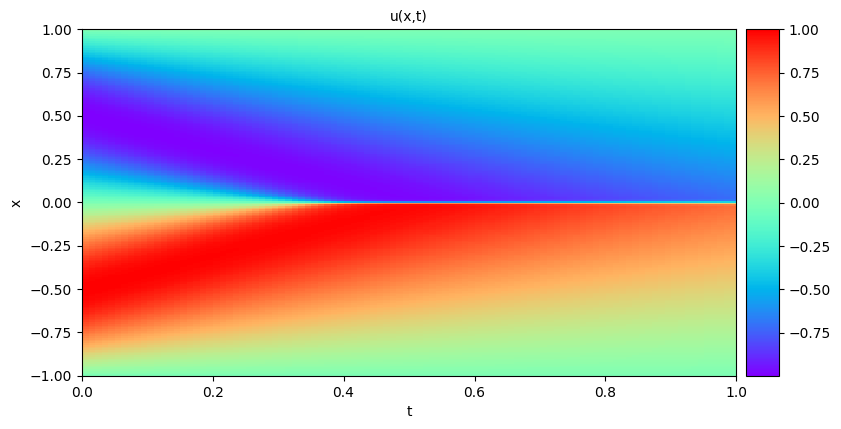

In [ ]:
#Plotting the solution

plot_solution()

**A few remarks:**

The solution generated here is very fast and accurate compared to other mesh-based numerical methods, To do an actual comparison we need to come up with other numerical methods solutions as well and then only we can compare the error/loss value.

Be careful while changing the parameters of the differential equations or the method that is used to generate training points in order to solve a similar differential equation or even the same one with a different boundary condition.